In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


## Step 1: quick look

In [3]:
filepath = 'weather_christchurch_daily.csv'

data = pd.read_csv(filepath, parse_dates=['time_index'], index_col='time_index')

data = data.sort_index()

data = data.asfreq('D')

data = data.drop(['weather_status_christchurch'], axis=1)

# Assuming 'df' is your DataFrame
data.columns = data.columns.str.replace('_christchurch', '')
data.columns = data.columns.str.replace('temperatures_', 'temp_')

df = data.copy()

print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1733 entries, 2019-01-01 to 2023-09-29
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rain_mm        1666 non-null   float64
 1   temp_max_c     1666 non-null   float64
 2   temp_min_c     1666 non-null   float64
 3   wind_speed_km  1666 non-null   float64
dtypes: float64(4)
memory usage: 67.7 KB
None


,rain_mm,temp_max_c,temp_min_c,wind_speed_km
time_index,,,,
2023-09-25,0.13,9.0,3.0,15.0
2023-09-26,0.03,10.0,2.0,22.0
2023-09-27,7.93,6.0,5.0,25.0
2023-09-28,10.67,13.0,4.0,25.0
2023-09-29,1.07,15.0,2.0,25.0


In [4]:
df.describe()

,rain_mm,temp_max_c,temp_min_c,wind_speed_km
count,1666.00000,1666.000000,1666.000000,1666.000000
mean,1.83569,15.862545,7.860144,21.070228
std,5.36455,5.223964,3.892428,8.368925
min,0.00000,5.000000,-4.000000,5.000000
25%,0.00000,12.000000,5.000000,15.000000
50%,0.00000,16.000000,8.000000,20.000000
75%,0.90000,19.000000,11.000000,26.000000
max,85.90000,33.000000,20.000000,72.000000


## Step 2: EDA

**1. Missing values**

In [5]:
import pandas as pd
from tabulate import tabulate

# Assuming 'df' is your DataFrame
missing_values = df.isnull().sum()
missing_indices = missing_values[missing_values > 0].index

# Create a table of missing values
table_data = []
for index in missing_indices:
    missing_count = df[index].isnull().sum()
    percent = (missing_count / len(df)) * 100
    table_data.append([index, missing_count, f"{percent:.2f}%"])

# Specify table headers
table_headers = ["Feature", "Missing Count", "Percentage"]

# Display the table
table = tabulate(table_data, headers=table_headers, tablefmt="pretty")
print(table)

+---------------+---------------+------------+
|    Feature    | Missing Count | Percentage |
+---------------+---------------+------------+
|    rain_mm    |      67       |   3.87%    |
|  temp_max_c   |      67       |   3.87%    |
|  temp_min_c   |      67       |   3.87%    |
| wind_speed_km |      67       |   3.87%    |
+---------------+---------------+------------+


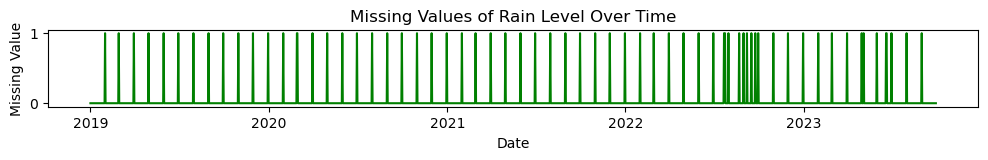

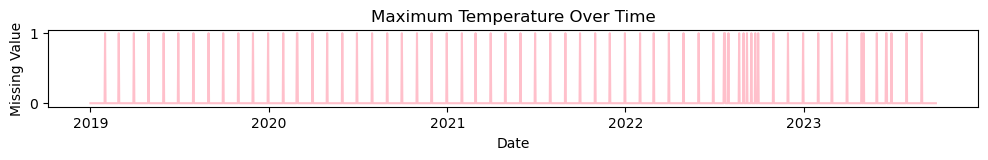

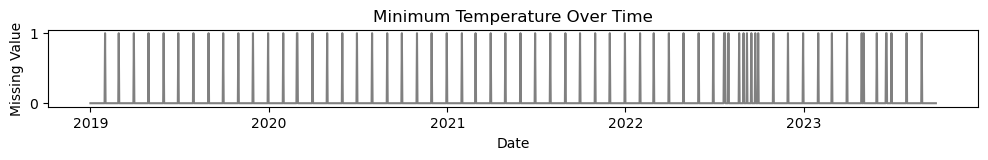

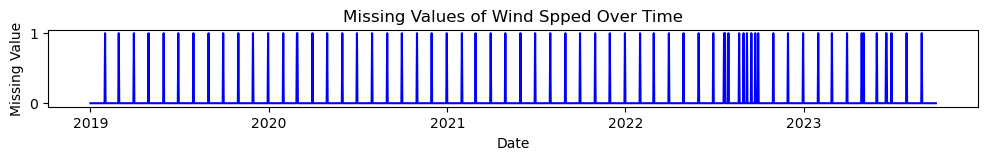

In [6]:
# Plotting missing values over time for each feature
plt.figure(figsize=(12, 1))
plt.plot(df.index, df['rain_mm'].isnull(), color='green')

plt.title('Missing Values of Rain Level Over Time')
plt.xlabel('Date')
plt.ylabel('Missing Value')
plt.show()

plt.figure(figsize=(12, 1))
plt.plot(df.index, df['temp_max_c'].isnull(), color='pink')

plt.title('Maximum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Missing Value')
plt.show()

plt.figure(figsize=(12, 1))
plt.plot(df.index, df['temp_min_c'].isnull(), color='gray')

plt.title('Minimum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Missing Value')
plt.show()


plt.figure(figsize=(12, 1))
plt.plot(df.index, df['wind_speed_km'].isnull(), color='blue')

plt.title('Missing Values of Wind Spped Over Time')
plt.xlabel('Date')
plt.ylabel('Missing Value')
plt.show()

In [7]:
missing_indices = df[df.isnull().any(axis=1)].index
print("Time indices of missing values:")
print(missing_indices)

Time indices of missing values:
DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-28', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-22',
               '2022-07-23', '2022-07-24', '2022-07-31', '2022-08-22',
               '2022-08-31', '2022-09-07', '2022-09-16', '2022-09-24',
               '2022-09-30', '2022-10-31', '2

In [8]:
## fill missing values on the temporary dataset 
df = df.fillna(method='ffill').fillna(method='bfill')

**2. Time Series Overview**

<class 'numpy.float64'>


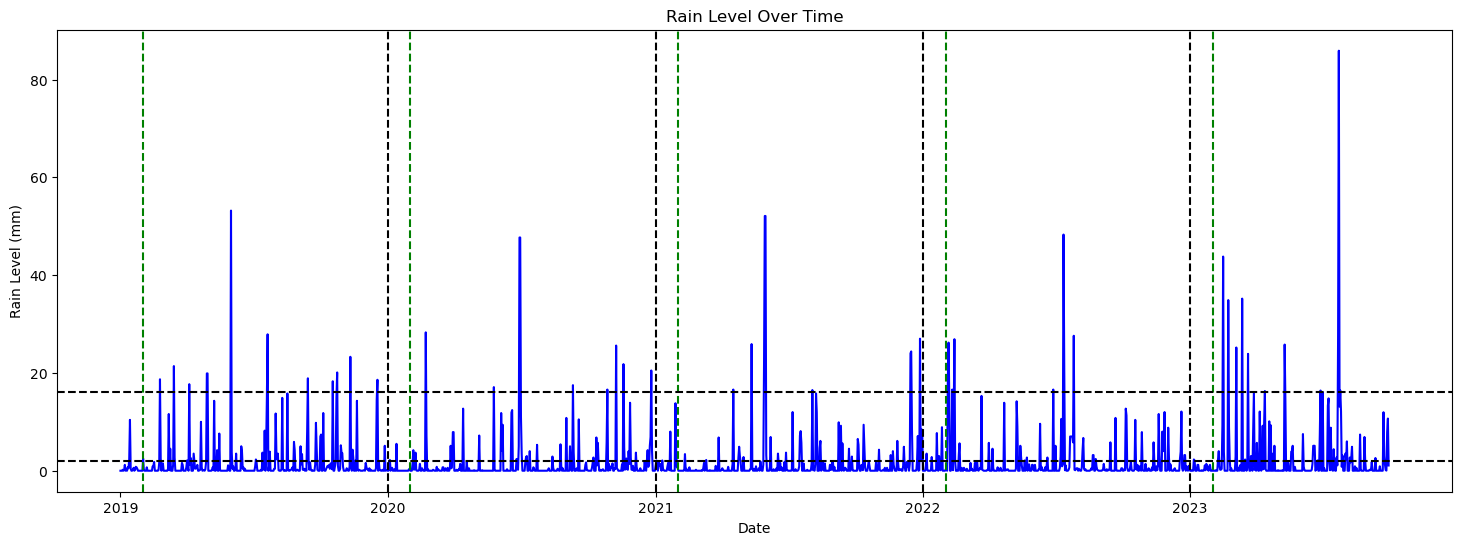

In [9]:
# visualization: time series line charts of rain level
data = df['rain_mm']
print(type(data[0]))

plt.figure(figsize=(18, 6))
plt.plot(data, label='Original', color='blue')

xcoords = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'])
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
xcoords = pd.to_datetime(['2019-02-1','2020-02-01', '2021-02-01', '2022-02-01', '2023-02-01'])
for xc in xcoords:
    plt.axvline(x=xc, color='green', linestyle='--')
    
plt.axhline(y=2, color='black', linestyle='--', label='Threshold')
plt.axhline(y=16, color='black', linestyle='--', label='Threshold')

# Decorations
plt.title('Rain Level Over Time')
plt.xlabel('Date')  # Add x-label
plt.ylabel('Rain Level (mm)')  # Add y-label
plt.show()

Insights:

1. Seasonal Patterns: a recurring pattern emerges, characterized by a six-month cycle of fluctuation. Notably, the rain level tends to peak towards the end of the first 6 months of each year. The rain level also tends to be consistently low in the first two months of annual Spring.
2. Temporal Changes: Throughout most of ther observed period from 01/01/2019 to the present, the rain level in the rain days typcially fall within the range of 2 to 16 mm. However, a distinctive deviation from this pattern is observed in the year 2023. During this specific year, there is a remarkable and significant increase in the rain level, nearly doubling compared to the previous years. 

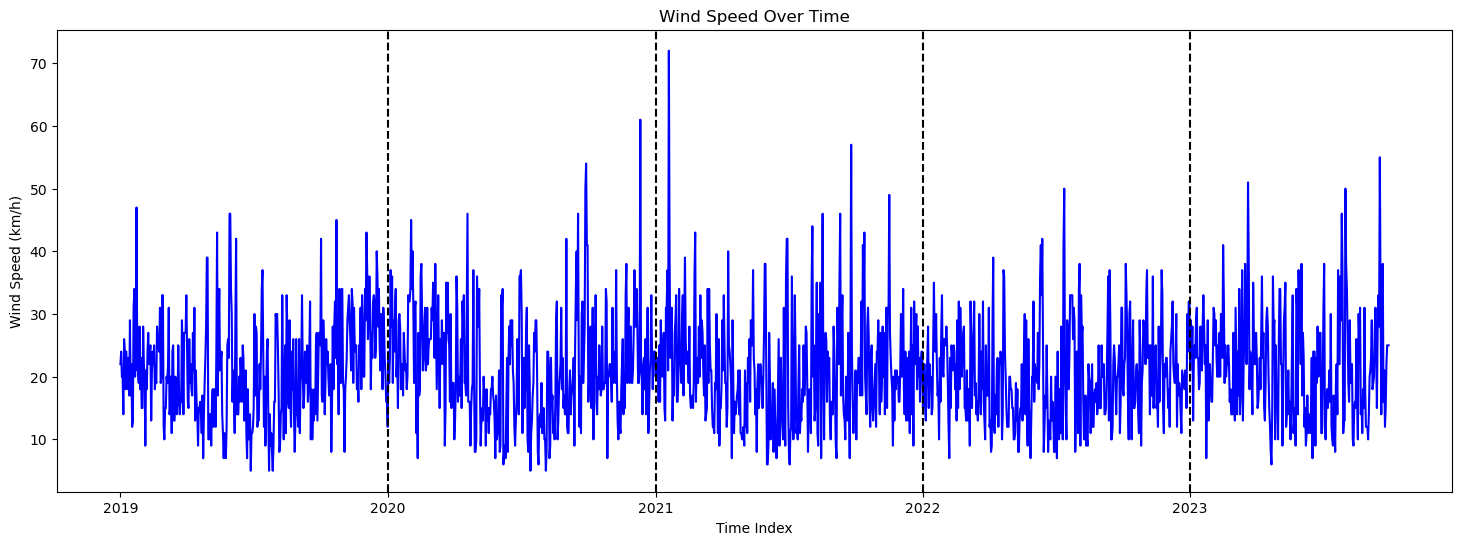

In [10]:
# Visualization: Time Series Line Charts of Wind Speed
data = df['wind_speed_km']

plt.figure(figsize=(18, 6))
plt.plot(data, label='Original', color='blue')

xcoords = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'])
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Decorations
plt.title('Wind Speed Over Time')
plt.xlabel('Time Index')
plt.ylabel('Wind Speed (km/h)')
plt.show()

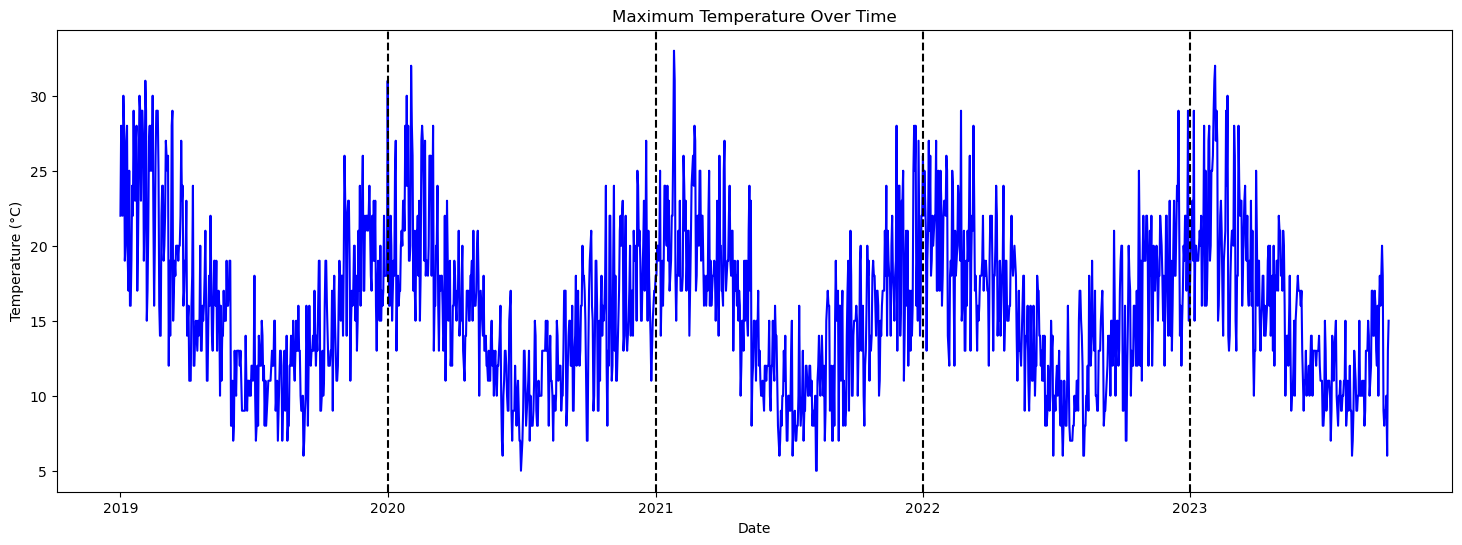

In [11]:
# Visualization: Time Series Line Chart of Maximum Temperature
data = df['temp_max_c']

plt.figure(figsize=(18, 6))
plt.plot(data, label='Original', color='blue')

xcoords = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'])
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Decorations
plt.title('Maximum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

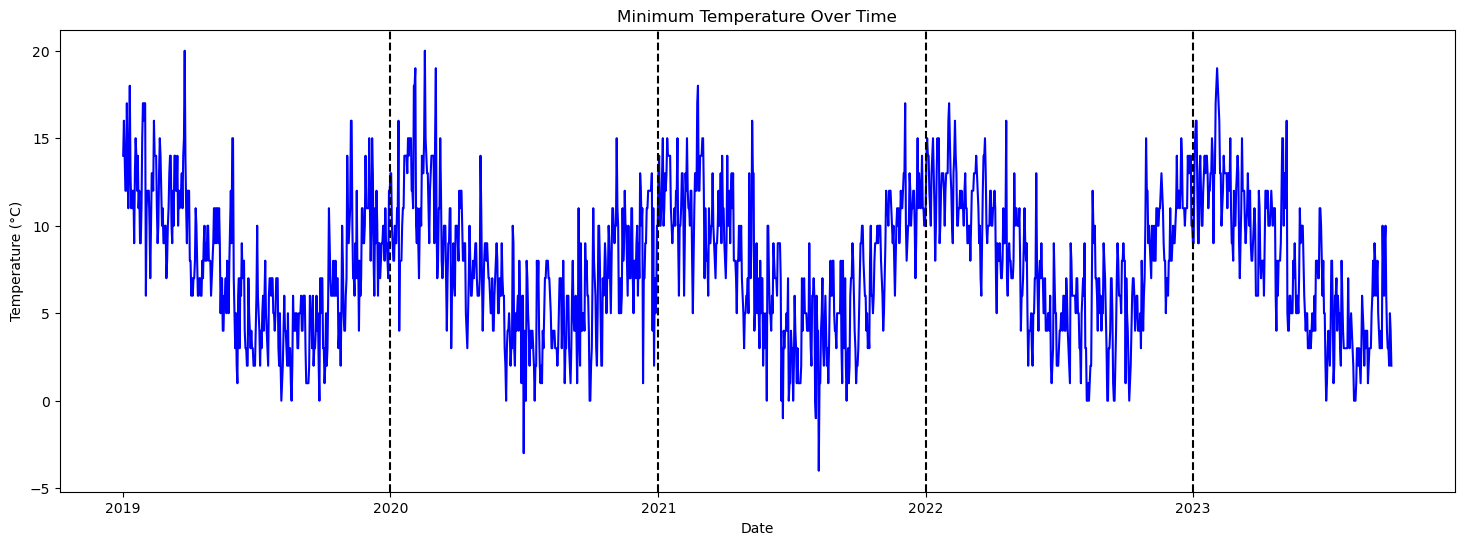

In [12]:
# Visualization: Time Series Line Chart of Minimum Temperature
data = df['temp_min_c']

plt.figure(figsize=(18, 6))
plt.plot(data, label='Original', color='blue')

xcoords = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'])
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Decorations
plt.title('Minimum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


**4. Correlation**

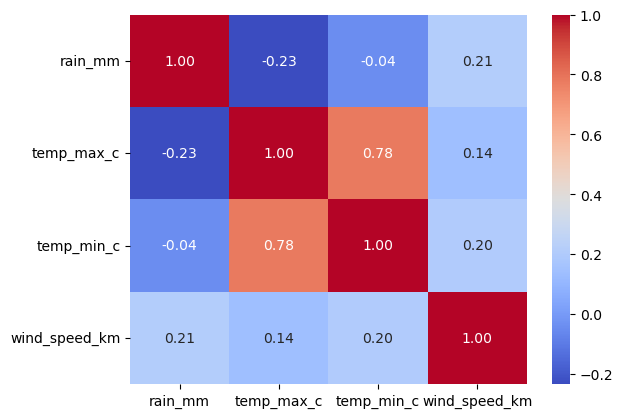

In [13]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Rainfall and Wind Speed: There is a positive correlation of approximately 0.21 between rain level and wind speed. This suggests that higher rainfall is associated with slightly increased wind speeds. This might indicate that windy conditions are more likely during periods of rainfall. However, the correlation is not very strong, and other factors may contribute to wind speed variations.

Temperature and Wind Speed: The correlation between maximum temperature and wind speed is relatively low (0.14), indicating a weak positive relationship. In contrast, the correlation between minimum temperature and wind speed is slightly stronger (0.2). Both suggests a modest positive association betweeen temperature and wind speed. This might indicate that higher temperatures may be associated with slightly increased wind speeds.

Temperature Interplay: The correlation between maximum and minimum temperatures is high (0.78), suggesting a strong positive relationship. This aligns with the general expectation that maximum and minimum temperatures tend to move in tandem. This interplay should be considered in the context of wind speed variations.



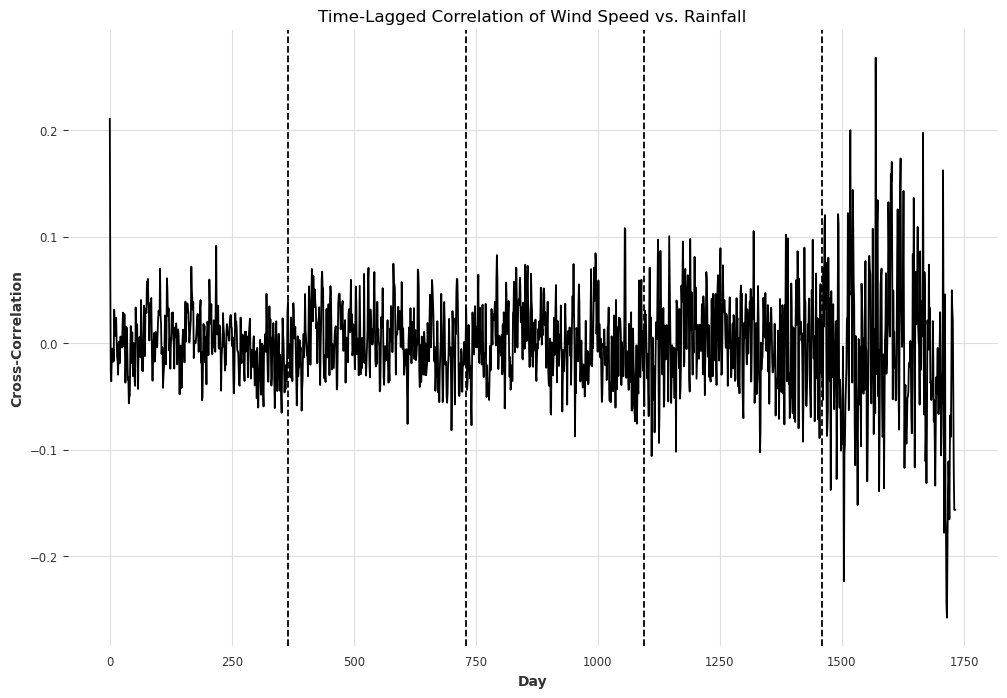

In [50]:
# Cross-correlation at different time lags
from statsmodels.tsa.stattools import ccf

plt.figure(figsize=(12, 8))
lagged_corr_rain = ccf(df['wind_speed_km'], df['rain_mm'])
plt.plot(lagged_corr_rain)

xcoords = (365*1, 365*2, 365*3, 365*4)
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

plt.xlabel('Day')
plt.ylabel('Cross-Correlation')
plt.title('Time-Lagged Correlation of Wind Speed vs. Rainfall')
plt.show()

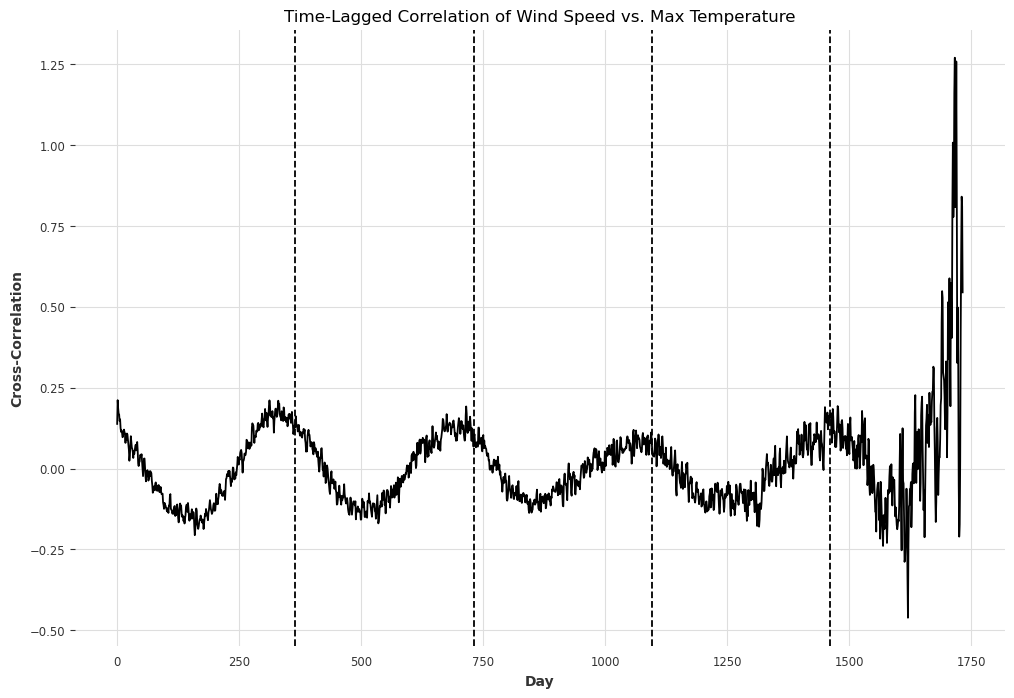

In [51]:
plt.figure(figsize=(12, 8))
lagged_corr_temp_max = ccf(df['wind_speed_km'], df['temp_max_c'])
plt.plot(lagged_corr_temp_max)

xcoords = (365*1, 365*2, 365*3, 365*4)
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

plt.xlabel('Day')
plt.ylabel('Cross-Correlation')
plt.title('Time-Lagged Correlation of Wind Speed vs. Max Temperature')
plt.show()

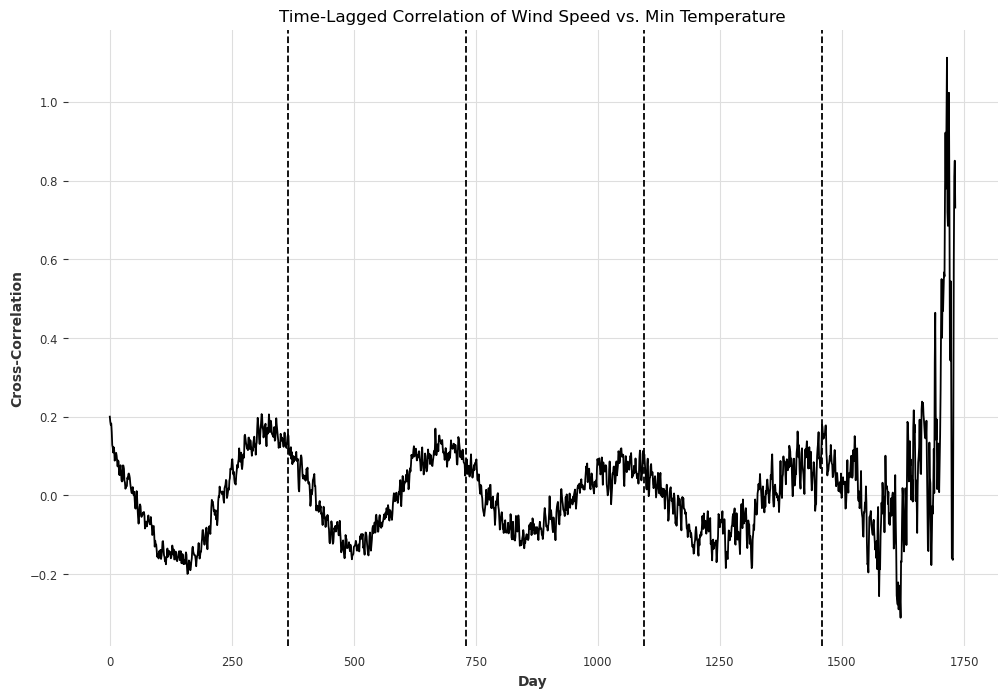

In [52]:
plt.figure(figsize=(12, 8))
lagged_corr_temp_min = ccf(df['wind_speed_km'], df['temp_min_c'])
plt.plot(lagged_corr_temp_min)

xcoords = (365*1, 365*2, 365*3, 365*4)
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.xlabel('Day')
plt.ylabel('Cross-Correlation')
plt.title('Time-Lagged Correlation of Wind Speed vs. Min Temperature')
plt.show()

Wind Speed vs. Rainfall: The electrocardiogram-like pattern indicates a cyclical relationship with a periodically of approximately 365 days (one year). The doubling variance after the day of 1500 could suggest a more complex or intensified positive relationship in the later time periods.

Wind Speed vs. Max Temperature and Min Temperature: The up and down cycle every year (365 days) may suggest a seasonal or periodic influence of temperatures on wind speed. The increasing cross-correlation values, particularly reaching high values beyond the day of 1500 (current year) might indicate a stronger positive influence in the later time periods.

## Step 3: Detailed Analysis Results

**1. Decomposition**

Trend Detection

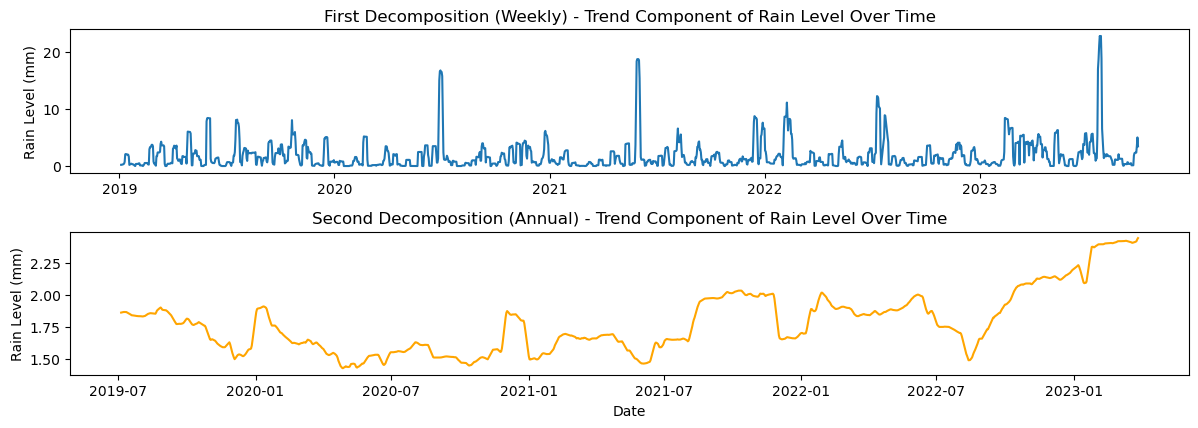

In [17]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['rain_mm'], model='additive', period=7)
trend_weekly = result_weekly.trend

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(trend_weekly.dropna(), model='additive', period=365)
trend_annual = result_annual.trend

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(trend_weekly, label='Weekly Trend')
plt.ylabel('Rain Level (mm)')
plt.title('First Decomposition (Weekly) - Trend Component of Rain Level Over Time')

plt.subplot(4, 1, 2)
plt.plot(trend_annual, label='Annual Trend', color='orange')
plt.ylabel('Rain Level (mm)')
plt.title('Second Decomposition (Annual) - Trend Component of Rain Level Over Time')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

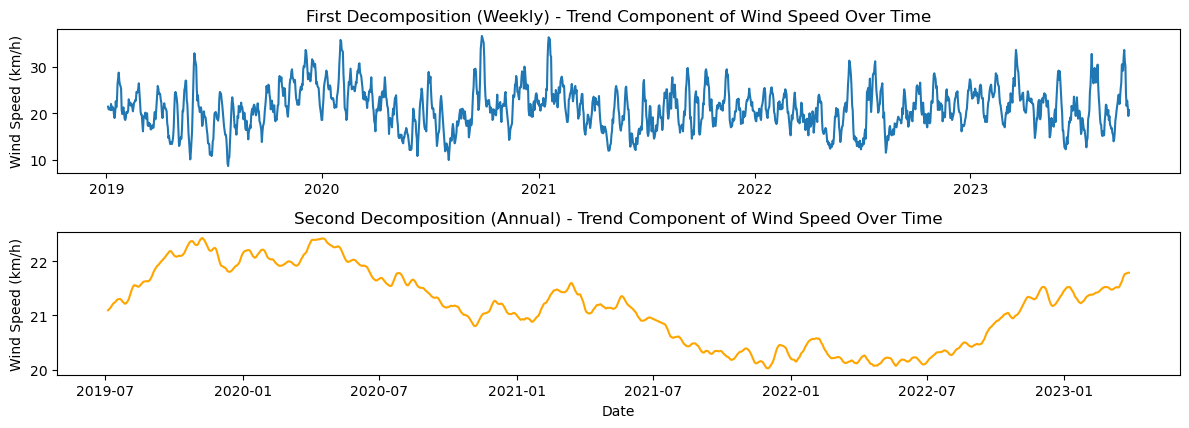

In [18]:
# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['wind_speed_km'], model='additive', period=7)
trend_weekly = result_weekly.trend

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(trend_weekly.dropna(), model='additive', period=365)
trend_annual = result_annual.trend

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(trend_weekly, label='Weekly Trend')
plt.ylabel('Wind Speed (km/h)')
plt.title('First Decomposition (Weekly) - Trend Component of Wind Speed Over Time')

plt.subplot(4, 1, 2)
plt.plot(trend_annual, label='Annual Trend', color='orange')
plt.ylabel('Wind Speed (km/h)')
plt.title('Second Decomposition (Annual) - Trend Component of Wind Speed Over Time')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

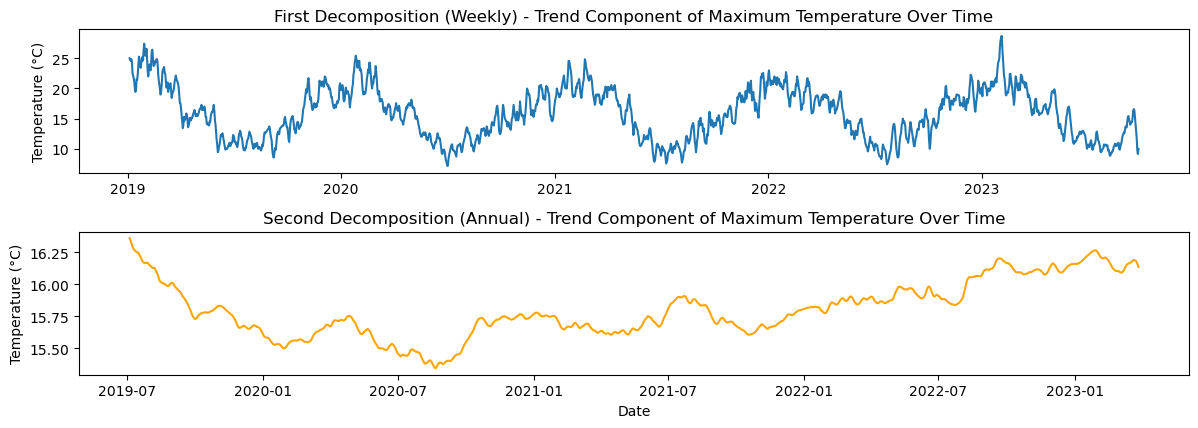

In [19]:
# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['temp_max_c'], model='additive', period=7)
trend_weekly = result_weekly.trend

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(trend_weekly.dropna(), model='additive', period=365)
trend_annual = result_annual.trend

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(trend_weekly, label='Weekly Trend')
plt.ylabel('Temperature (°C)')
plt.title('First Decomposition (Weekly) - Trend Component of Maximum Temperature Over Time')

plt.subplot(4, 1, 2)
plt.plot(trend_annual, label='Annual Trend', color='orange')
plt.ylabel('Temperature (°C)')
plt.title('Second Decomposition (Annual) - Trend Component of Maximum Temperature Over Time')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

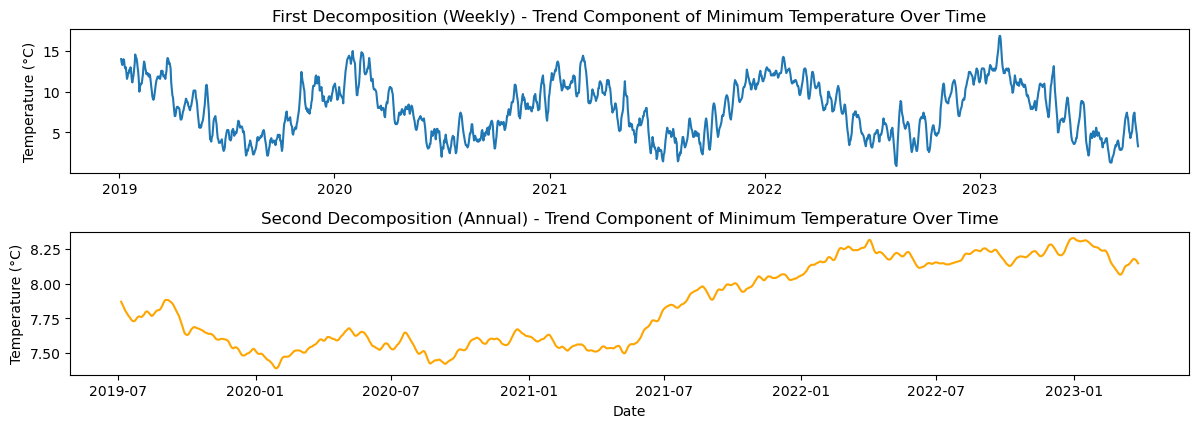

In [20]:
# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['temp_min_c'], model='additive', period=7)
trend_weekly = result_weekly.trend

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(trend_weekly.dropna(), model='additive', period=365)
trend_annual = result_annual.trend

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(trend_weekly, label='Weekly Trend')
plt.ylabel('Temperature (°C)')
plt.title('First Decomposition (Weekly) - Trend Component of Minimum Temperature Over Time')

plt.subplot(4, 1, 2)
plt.plot(trend_annual, label='Annual Trend', color='orange')
plt.ylabel('Temperature (°C)')
plt.title('Second Decomposition (Annual) - Trend Component of Minimum Temperature Over Time')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

While there are fluctuations, the rainfall data indicates an upward trend, especially since the mid of 2022.

There is no apparent trend during the entire timeline. The wind speed data has shown downward through years from 2019 to 2021 and upward from 2022 until now. They are actually part of a long cycle, but when viewed only those years, it could be considered as a downward trend.

While there are fluctuations, both the maximum and minimum temperature data indicates upward trends, especially since the mid of 2021.

Seasonality Detection

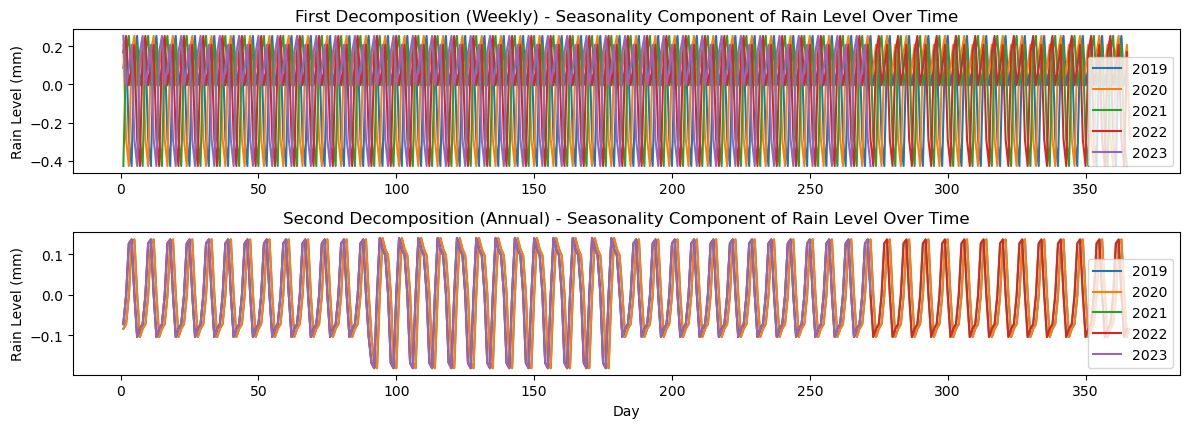

In [21]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['rain_mm'], model='additive', period=7)
seasonal_weekly = result_weekly.seasonal

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(seasonal_weekly.dropna(), model='additive', period=365)
seasonal_annual = result_annual.seasonal

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
#plt.plot(seasonal_daily, label='Weekly Seasonality')
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_weekly[seasonal_weekly.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()    
    
plt.ylabel('Rain Level (mm)')
plt.title('First Decomposition (Weekly) - Seasonality Component of Rain Level Over Time')

plt.subplot(4, 1, 2)
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_annual[seasonal_annual.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()

#plt.plot(seasonal_annual, label='Annual Seasonality')
plt.ylabel('Rain Level (mm)')
plt.title('Second Decomposition (Annual) - Seasonality Component of Rain Level Over Time')

plt.xlabel('Day')
plt.tight_layout()
plt.show()

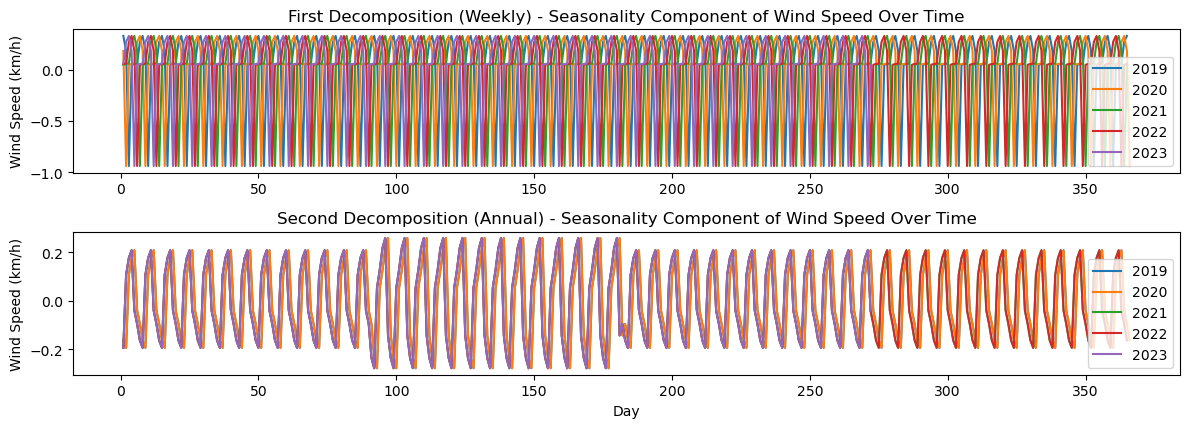

In [22]:
# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['wind_speed_km'], model='additive', period=7)
seasonal_weekly = result_weekly.seasonal

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(seasonal_weekly.dropna(), model='additive', period=365)
seasonal_annual = result_annual.seasonal

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
#plt.plot(seasonal_daily, label='Weekly Seasonality')
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_weekly[seasonal_weekly.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()    
    
plt.ylabel('Wind Speed (km/h)')
plt.title('First Decomposition (Weekly) - Seasonality Component of Wind Speed Over Time')

plt.subplot(4, 1, 2)
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_annual[seasonal_annual.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()

#plt.plot(seasonal_annual, label='Annual Seasonality')
plt.ylabel('Wind Speed (km/h)')
plt.title('Second Decomposition (Annual) - Seasonality Component of Wind Speed Over Time')

plt.xlabel('Day')
plt.tight_layout()
plt.show()

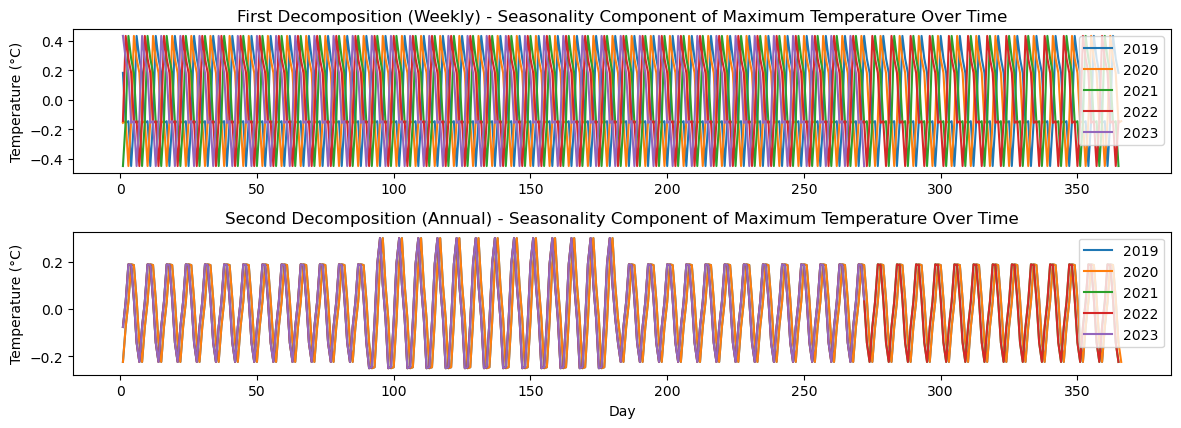

In [23]:
# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['temp_max_c'], model='additive', period=7)
seasonal_weekly = result_weekly.seasonal

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(seasonal_weekly.dropna(), model='additive', period=365)
seasonal_annual = result_annual.seasonal

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
#plt.plot(seasonal_daily, label='Weekly Seasonality')
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_weekly[seasonal_weekly.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()    
    
plt.ylabel('Temperature (°C)')
plt.title('First Decomposition (Weekly) - Seasonality Component of Maximum Temperature Over Time')

plt.subplot(4, 1, 2)
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_annual[seasonal_annual.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()

plt.ylabel('Temperature (°C)')
plt.title('Second Decomposition (Annual) - Seasonality Component of Maximum Temperature Over Time')

plt.xlabel('Day')
plt.tight_layout()
plt.show()

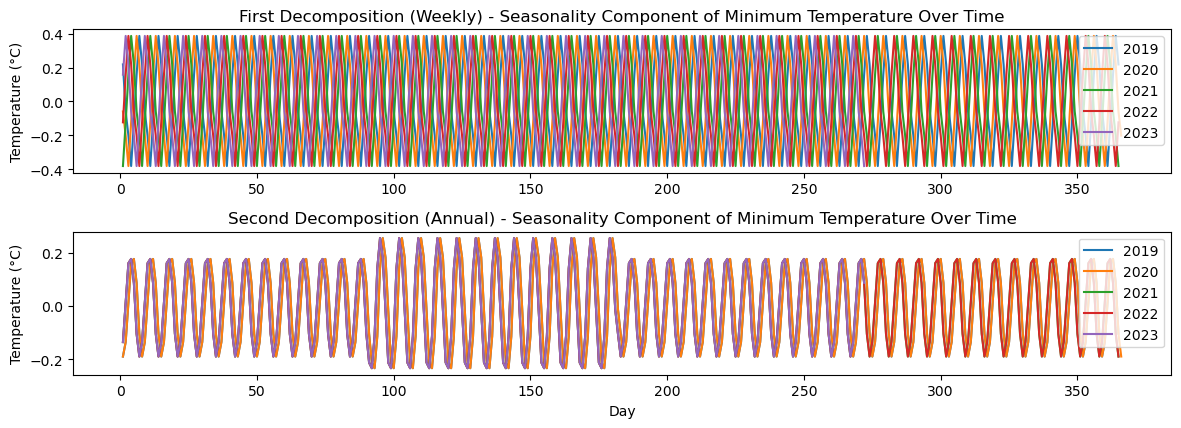

In [24]:
# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['temp_min_c'], model='additive', period=7)
seasonal_weekly = result_weekly.seasonal

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(seasonal_weekly.dropna(), model='additive', period=365)
seasonal_annual = result_annual.seasonal

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
#plt.plot(seasonal_daily, label='Weekly Seasonality')
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_weekly[seasonal_weekly.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()    
    
plt.ylabel('Temperature (°C)')
plt.title('First Decomposition (Weekly) - Seasonality Component of Minimum Temperature Over Time')

plt.subplot(4, 1, 2)
for year in range(df.index.year.min(), df.index.year.max() + 1):
    season_df = seasonal_annual[seasonal_annual.index.year == year]
    x_values = np.arange(1, len(season_df)+1)
    plt.plot(x_values, season_df, label=year)
plt.legend()

plt.ylabel('Temperature (°C)')
plt.title('Second Decomposition (Annual) - Seasonality Component of Minimum Temperature Over Time')

plt.xlabel('Day')
plt.tight_layout()
plt.show()

Through the time series of wind speed, minimum and maximum temperatures, and rainfall, they are all showing strong seasonality within each year.

Irregular remainder

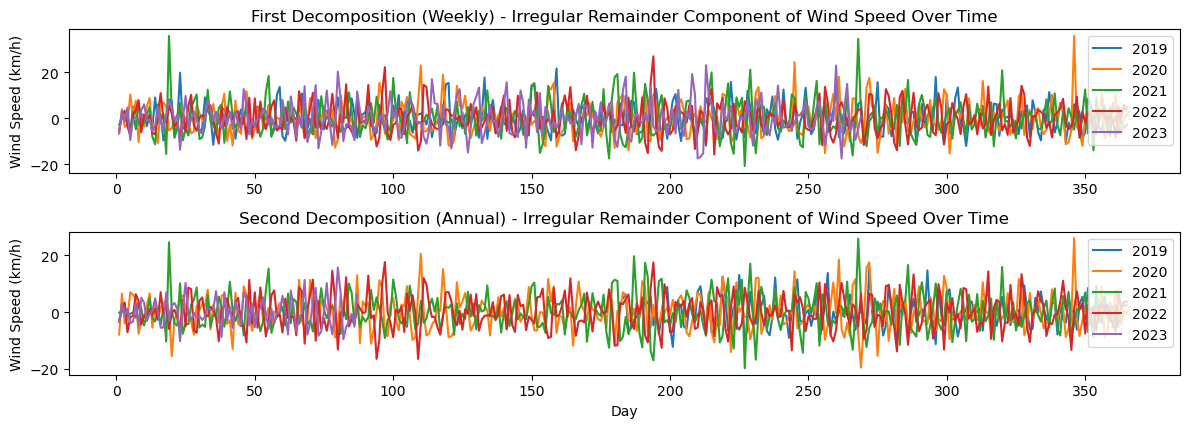

In [25]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Step 1: Decompose weekly seasonality
result_weekly = seasonal_decompose(df['wind_speed_km'], model='additive', period=7)
resid_weekly = result_weekly.resid

# Step 2: Decompose annual seasonality from the remaining trend
result_annual = seasonal_decompose(resid_weekly.dropna(), model='additive', period=365)
resid_annual = result_annual.resid

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
for year in range(df.index.year.min(), df.index.year.max() + 1):
    resid_df = resid_weekly[resid_weekly.index.year == year]
    x_values = np.arange(1, len(resid_df)+1)
    plt.plot(x_values, resid_df, label=year)
plt.legend()    
    
plt.ylabel('Wind Speed (km/h)')
plt.title('First Decomposition (Weekly) - Irregular Remainder Component of Wind Speed Over Time')

plt.subplot(4, 1, 2)
for year in range(df.index.year.min(), df.index.year.max() + 1):
    resid_df = resid_annual[resid_annual.index.year == year]
    x_values = np.arange(1, len(resid_df)+1)
    plt.plot(x_values, resid_df, label=year)
plt.legend()

plt.ylabel('Wind Speed (km/h)')
plt.title('Second Decomposition (Annual) - Irregular Remainder Component of Wind Speed Over Time')

plt.xlabel('Day')
plt.tight_layout()
plt.show()

**2. Stationarity**

Non-stationarity can lead to biased estimates and unreliable forecasts. More specifically, using non-stationary time series in regression models can lead to a high R-squared value and statistically significant regression coefficients. These results are very likely misleading or spurious. 

If the original time series is not stationary, some approaches could be used to make it stationary. They are differencing, de-trending, seasonal differeencing, transformation, ARIMA modeling, or trend and seasonal decomposition techniques.

Stationarity means that the statistical properties of a process generating a time series do not change over time. Certain models and techniques work better with stationarity time series.

The augmented Dickey-Fuller test is used here to test the null hypothesis that a unit root present in a time sample. The alternative hypothesis is stationarity. 

In [27]:
from statsmodels.tsa.stattools import adfuller
from prettytable import PrettyTable

def adfuller_test(series, signif=0.05, name=''):
    result = adfuller(series, autolag='AIC')
    stat = round(result[0], 2)
    p_value = round(result[1], 3)

    return [name, stat, p_value, 'Stationary' if p_value <= signif else 'Non-Stationary']

# Assuming df is your DataFrame with columns to be tested
results = []

for name, column in df.items():
    result = adfuller_test(column, name=name)
    results.append(result)

# Create a PrettyTable
table = PrettyTable(['Name', 'ADF Statistic', 'p-value', 'Result'])
for result in results:
    table.add_row(result)

# Print the table
print(table)


+---------------+---------------+---------+------------+
|      Name     | ADF Statistic | p-value |   Result   |
+---------------+---------------+---------+------------+
|    rain_mm    |     -25.99    |   0.0   | Stationary |
|   temp_max_c  |     -3.37     |  0.012  | Stationary |
|   temp_min_c  |     -3.56     |  0.007  | Stationary |
| wind_speed_km |     -16.91    |   0.0   | Stationary |
+---------------+---------------+---------+------------+


Because the time series of all of them are stationary at level as they originally are, they are integrated of order 0. 

**3. AR and MA terms**

The ARMA(p,q), Autoregressive Moving Average model, is a combination of AR(p) and MA(q) models. This model predicts future values based on past values and has two parameters, p and q, which respectively define the order of the autoregressive part (AR) and moving average part (MA).

ACF and PACF plots have been used to identify the order of AR and MA terms. All spikes outside the blue boundary of these plots could tell the orders, p and q.

An AR signature corresponds to a PACF plot displaying a sharp cut-off and a more slowly decaying ACF. An MA signature corresponds to an ACF plot displaying a sharp cut-off and a PACF plot that decays more slowly.

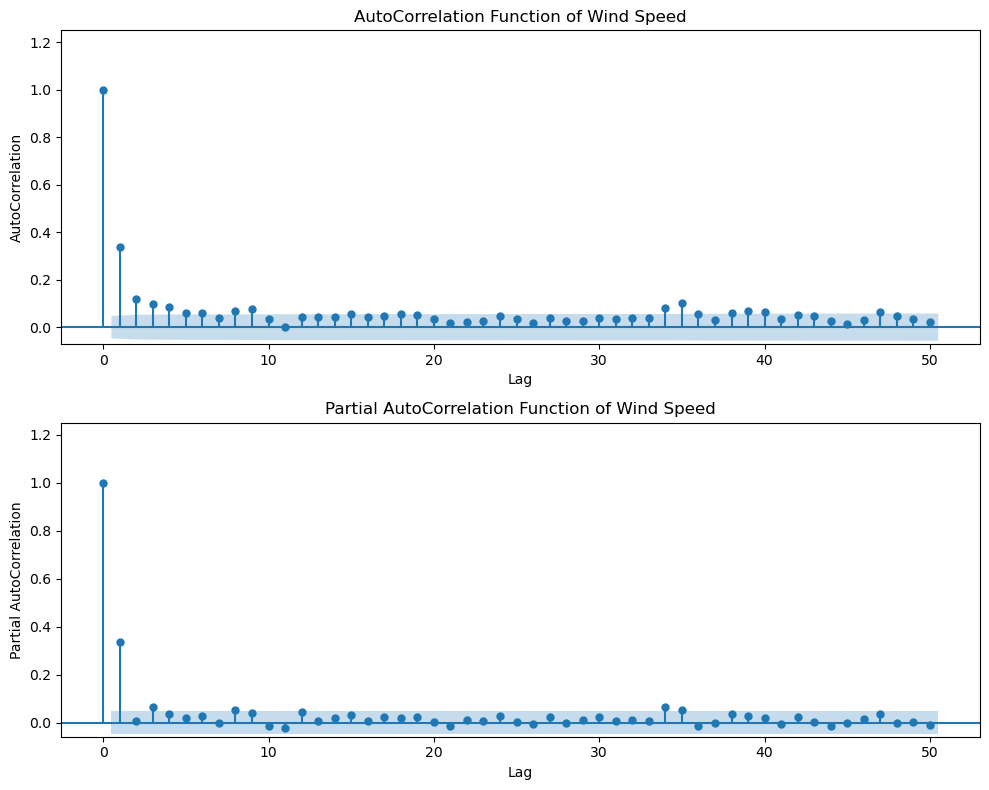

In [28]:
## AutoCorrelation Function (ACF) and Partial Autocorrelation (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Flatten axes for iteration
axes = axes.flatten()

plot_acf(df['wind_speed_km'], lags=50, ax=axes[0], title=f'AutoCorrelation Function of Wind Speed', auto_ylims=True)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('AutoCorrelation')

plot_pacf(df['wind_speed_km'], lags=50, ax=axes[1], title=f'Partial AutoCorrelation Function of Wind Speed', auto_ylims=True)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial AutoCorrelation')

plt.tight_layout()
plt.show()

From the ACF and PACF plots for the Wind Speed, we can try using p = 1. In order to select q for the MA model, we can try using q = 1 or q = 2.

## Step 4: Train-test split

In [30]:
from darts import TimeSeries

# forecast the next 30 days
nobs = 60

## Multivariate time-series
train, test = df[:-nobs], df[-nobs:]

## Step 5: Data Preprocessing

If any distribution is not normal, MinMaxScaler is applicable. The StandardScaler is used in casethe data that has an approximately normal distribution. However, it is not used here. In the context of multivariate time series forecasting, if modeling techniques such as Neural Networks benefit from having inputs on a similar scale.

There is no need to do any transformation techniques such as differencing because all variables are stationarity.

## Step 4: Modeling and Forecasting Results

In [31]:
from darts.metrics import coefficient_of_variation, mae, rmse, mse, mape, smape
from darts.models import ExponentialSmoothing, ARIMA, AutoARIMA

from prophet import Prophet

The dataset is only a set of wind speed data. The training data consists of observations from January 2019 to June 2023. The testing data includes the most recent 30 days' observations from July 2023 to August 2023.

Algorithms: ARIMA, SARIMA, Facebook Prophet

p=1, q = 1 or q = 2, and d=1 => possible tries: ARIMA(1,0,1) and ARIMA(1,0,2)

m = 365 => SARIMA

**2. Multivariate time series**

In [32]:
# Import Statsmodels
#from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR

1. find the lag order returning the best fit

In [38]:
model = VAR(df)

best_criteria_aic = np.inf  
best_criteria_bic = np.inf  
best_lag_aic = 0
best_lag_bic = 0

for lag_order in range(1, 200):
    result = model.fit(lag_order)
    
    aic = result.aic
    bic = result.bic
    fpe = result.fpe
    hqic = result.hqic

    if aic < best_criteria_aic:
        best_criteria_aic = aic
        best_lag_aic = lag_order
        
    if bic < best_criteria_bic:
        best_criteria_bic = bic
        best_lag_bic = lag_order
        
    #print('Lag Order =', lag_order, ' - AIC : ', round(aic, 3), ' BIC : ', round(bic, 3), ' FPE : ', round(fpe, 3), ' HQIC: ', round(hqic, 3))
print('--------------------------------------------------------')    
print("Best Lag Order by AIC:", best_lag_aic) 
print('--------------------------------------------------------')
print("Best Lag Order by BIC:", best_lag_bic) 

--------------------------------------------------------
Best Lag Order by AIC: 10
--------------------------------------------------------
Best Lag Order by BIC: 1


Conclusion: let's go with the lag order of 1 and 10

2. Model fitting and predicting


Durbin-Watson Statistic for Lag Order 10:
+---------------+---------------+
|     Column    | Durbin-Watson |
+---------------+---------------+
|    rain_mm    |      2.00     |
|   temp_max_c  |      2.00     |
|   temp_min_c  |      2.01     |
| wind_speed_km |      2.00     |
+---------------+---------------+


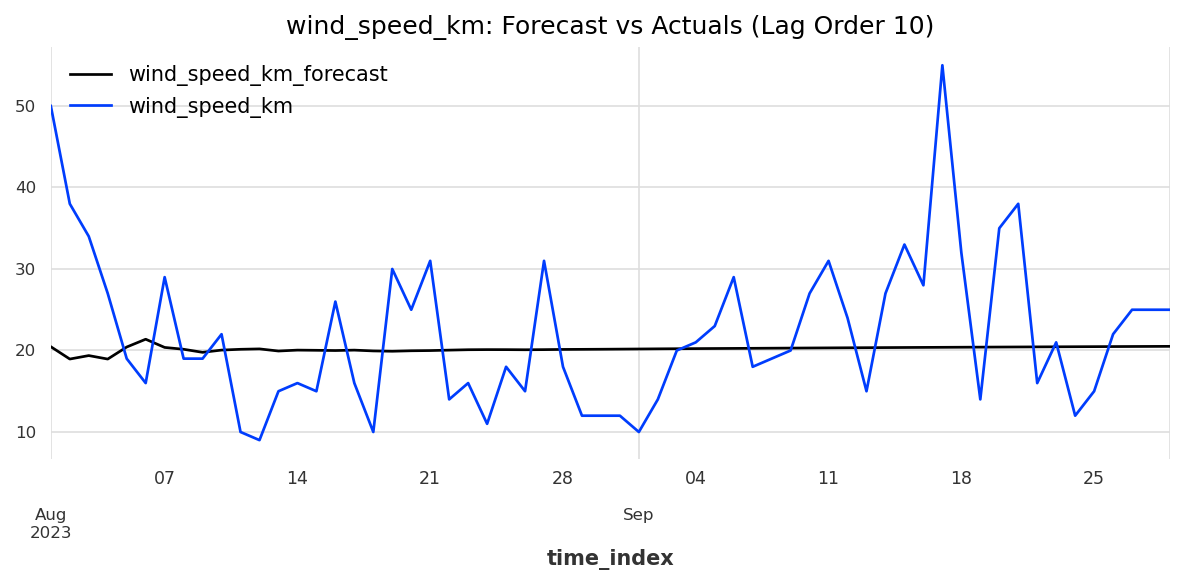


Durbin-Watson Statistic for Lag Order 1:
+---------------+---------------+
|     Column    | Durbin-Watson |
+---------------+---------------+
|    rain_mm    |      1.95     |
|   temp_max_c  |      2.08     |
|   temp_min_c  |      2.12     |
| wind_speed_km |      1.99     |
+---------------+---------------+


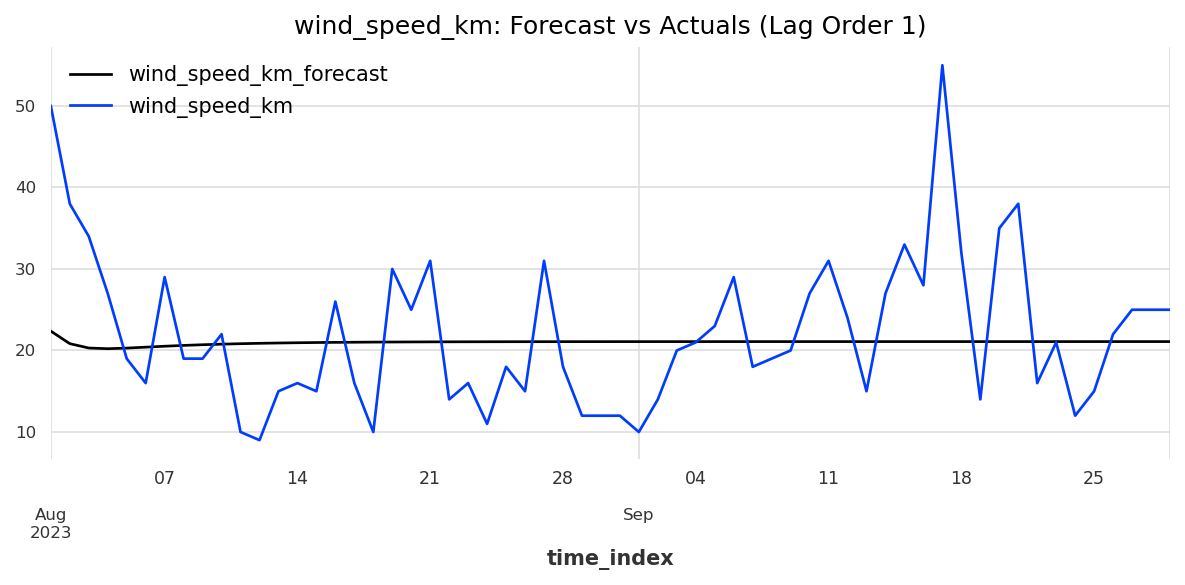


Performance Metrics Comparison:
+-----------+------+------+-------+-------+
| Lag Order | MAE  | RMSE | MAPE  |  R2   |
+-----------+------+------+-------+-------+
|  Lag 10   | 7.34 | 9.65 | 35.33 | -0.05 |
|   Lag 1   | 7.33 | 9.43 | 36.76 | -0.0  |
+-----------+------+------+-------+-------+


In [43]:
from prettytable import PrettyTable
from tabulate import tabulate
from statsmodels.stats.stattools import durbin_watson
from darts.metrics import mape, rmse, mae, r2_score
import matplotlib.pyplot as plt

# Assuming best_lag_aic and best_lag_bic are calculated earlier
lag_order_aic = best_lag_aic
lag_order_bic = best_lag_bic

# Dictionary to store metrics for each lag order
metrics_data = {}

for lag_order in [lag_order_aic, lag_order_bic]:
    # Fit the model for the current lag order
    model_fitted = model.fit(lag_order)

    # Calculate Durbin-Watson statistic
    out = durbin_watson(model_fitted.resid)

    # Create a table
    table = PrettyTable()
    table.field_names = ['Column', 'Durbin-Watson']

    # Add data to the table
    for col, val in zip(df.columns, out):
        table.add_row([col, f'{val:.2f}'])

    # Print the table
    print(f'\nDurbin-Watson Statistic for Lag Order {lag_order}:')
    print(table)

    # Input data for forecasting
    forecast_input = df.values[-nobs:]

    # Forecast for the next nobs days
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(
        fc, index=df.index[-nobs:],
        columns=['rain_mm_forecast', 'temp_max_c_forecast', 'temp_min_c_forecast', 'wind_speed_km_forecast']
    )

    # Plot forecast vs actual for wind_speed_km
    fig, ax = plt.subplots(dpi=150, figsize=(8, 4))
    df_forecast['wind_speed_km_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    df[['wind_speed_km']][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(f"wind_speed_km: Forecast vs Actuals (Lag Order {lag_order})")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
    plt.tight_layout()
    plt.show()

    # Performance metrics
    val_origin = TimeSeries.from_dataframe(
        df[['wind_speed_km']][-nobs:], value_cols='wind_speed_km'
    )
    pred_origin = TimeSeries.from_dataframe(
        df_forecast, value_cols='wind_speed_km_forecast'
    )

    # Calculate performance metrics
    mae_val = mae(val_origin, pred_origin)
    rmse_val = rmse(val_origin, pred_origin)
    mape_val = mape(val_origin, pred_origin)
    r2_val = r2_score(val_origin, pred_origin)    

    # Store metrics in the dictionary
    metrics_data[f'Lag {lag_order}'] = {
        'MAE': round(mae_val,2),
        'RMSE': round(rmse_val,2),
        'MAPE': round(mape_val,2),
        'R2': round(r2_val,2)        
    }

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).T.reset_index()
metrics_df.rename(columns={'index': 'Lag Order'}, inplace=True)

# Display the metrics table
print('\nPerformance Metrics Comparison:')
print(tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False))


The Lag 1 model has a slightly lower MAE and RMSE, indicating better accuracy in point predictions, but the Lag 10 model has a lower MAPE, which suggests better performance in terms of percentage errors. We can choose either the lag value of 1 or 10.

In comparison to the univariate timeseries of Wind Speed, there seems to be no enhancement in forecasting when incorporating additional variables such as Rainfall, Temperature alongside Wind Speed.